In [1]:
from __future__ import print_function
from functools import reduce
import json
import os
import re
import tarfile
import tempfile

import numpy as np
np.random.seed(1337)  # for reproducibility

'''
300D Model - Train / Test (epochs)
=-=-=
Batch size = 512
Fixed GloVe
- 300D SumRNN + Translate + 3 MLP (1.2 million parameters) - 0.8315 / 0.8235 / 0.8249 (22 epochs)
- 300D GRU + Translate + 3 MLP (1.7 million parameters) - 0.8431 / 0.8303 / 0.8233 (17 epochs)
- 300D LSTM + Translate + 3 MLP (1.9 million parameters) - 0.8551 / 0.8286 / 0.8229 (23 epochs)
Following Liu et al. 2016, I don't update the GloVe embeddings during training.
Unlike Liu et al. 2016, I don't initialize out of vocabulary embeddings randomly and instead leave them zeroed.
The jokingly named SumRNN (summation of word embeddings) is 10-11x faster than the GRU or LSTM.
Original numbers for sum / LSTM from Bowman et al. '15 and Bowman et al. '16
=-=-=
100D Sum + GloVe - 0.793 / 0.753
100D LSTM + GloVe - 0.848 / 0.776
300D LSTM + GloVe - 0.839 / 0.806
'''

import keras
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import merge, recurrent, Dense, Input, Dropout, TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
from keras.utils import np_utils

In [2]:
# LPH = Label, Premise, Hypothesis
def getLPH(fileName):
  l = []
  for _, line in enumerate(open(fileName)):
    jsonData = json.loads(line)
    label = jsonData['gold_label']
    # print(jsonData['sentence2_binary_parse'])
    getToks = lambda s: ' '.join(s.replace('(', ' ').replace(')', ' ').replace('-LRB-', '(').replace('-RRB-', ')').lower().split())
    p = "<s> " + getToks(jsonData['sentence1_binary_parse'])
    h = "<s> " + getToks(jsonData['sentence2_binary_parse'])
    # print(h)

    # no majority among turks
    if label == '-':
      continue

    l.append((label, p, h))
  return l

def getData(fileName):
  data = getLPH(fileName=fileName)
  Ps = [x[1] for x in data]
  Hs = [x[2] for x in data]
  # print(max(len(x.split()) for x in Ps))
  # print(max(len(x.split()) for x in Hs))

  LABELS = {'contradiction': 0, 'neutral': 1, 'entailment': 2}
  Y = np.array([LABELS[x[0]] for x in data])
  Y = np_utils.to_categorical(Y, len(LABELS))
  
  return Ps, Hs, Y

training = getData('/content/drive/MyDrive/nli-datasets/snli/snli_1.0/snli_1.0_train.jsonl')
validation = getData('/content/drive/MyDrive/nli-datasets/snli/snli_1.0/snli_1.0_dev.jsonl')
test = getData('/content/drive/MyDrive/nli-datasets/snli/snli_1.0/snli_1.0_test.jsonl')



tokenizer = Tokenizer(filters = '!"#$%&()*+,-/:;=?@[\\]^_`{|}~\t\n', oov_token="<unk>")
tokenizer.fit_on_texts(training[0] + training[1])

In [3]:
# for i in range(5000):
# 	print(training[2][i] , " : [", training[0][i] , "]<->[", training[1][i] , "]")

In [4]:
tokenizer.get_config()

{'char_level': False,
 'document_count': 1098734,
 'filters': '!"#$%&()*+,-/:;=?@[\\]^_`{|}~\t\n',
 'index_docs': '{"197": 7126, "1154": 742, "79": 16919, "4": 962423, "3": 1098734, "9": 221231, "39": 39162, "207": 6625, "43": 35531, "2": 797260, "801": 1201, "742": 1339, "119": 11448, "18": 96201, "10": 182030, "163": 8539, "56": 26414, "36": 42944, "219": 6137, "27": 57301, "7": 360283, "5": 422784, "12": 173240, "94": 13399, "6": 348405, "280": 4623, "373": 3158, "318": 3794, "100": 12701, "95": 13221, "341": 3533, "91": 13973, "20": 76892, "139": 9805, "13": 155298, "29": 55614, "1742": 396, "365": 3306, "1969": 338, "80": 16606, "256": 5060, "21": 66410, "509": 2172, "659": 1601, "8": 257613, "102": 12707, "158": 8733, "82": 16296, "15": 120271, "49": 28298, "11": 195125, "864": 1102, "45": 34024, "482": 2323, "16": 119955, "166": 8325, "276": 4753, "239": 5674, "510": 2191, "22": 58832, "92": 13418, "70": 19179, "466": 2397, "446": 2579, "52": 29205, "71": 18294, "512": 2177, "88

In [5]:

#RNN = recurrent.LSTM
#RNN = lambda *args, **kwargs: Bidirectional(recurrent.LSTM(*args, **kwargs))
#RNN = recurrent.GRU
#RNN = lambda *args, **kwargs: Bidirectional(recurrent.GRU(*args, **kwargs))

# Summation of word embeddings
RNN = None
LAYERS = 1
USE_GLOVE = True
TRAIN_EMBED = False
EMBED_HIDDEN_SIZE = 300
SENT_HIDDEN_SIZE = 300
BATCH_SIZE = 512
PATIENCE = 8
MAX_EPOCHS = 42
MAX_LEN = 42
DP = 0.2
L2 = 4e-6
ACTIVATION = 'relu'
OPTIMIZER = 'rmsprop'
print('RNN / Embed / Sent = {}, {}, {}'.format(RNN, EMBED_HIDDEN_SIZE, SENT_HIDDEN_SIZE))
print('GloVe / Trainable Word Embeddings = {}, {}'.format(USE_GLOVE, TRAIN_EMBED))

RNN / Embed / Sent = None, 300, 300
GloVe / Trainable Word Embeddings = True, False


In [6]:
# Lowest index from the tokenizer is 1 - we need to include 0 in our vocab count
VOCAB = len(tokenizer.word_counts) + 2
LABELS = {'contradiction': 0, 'neutral': 1, 'entailment': 2}



to_seq = lambda X: pad_sequences(tokenizer.texts_to_sequences(X), maxlen=MAX_LEN)
prepare_data = lambda data: (to_seq(data[0]), to_seq(data[1]), data[2])

training = prepare_data(training)
validation = prepare_data(validation)
test = prepare_data(test)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
VOCAB

33422

In [9]:
print('Build model...')
print('Vocab size =', VOCAB)

GLOVE_STORE = '/content/drive/MyDrive/GloVe-Embeddings/precomputed_glove.weights'
if USE_GLOVE:
  if not os.path.exists(GLOVE_STORE):
    print('Computing GloVe')
  
    embeddings_index = {}
    f = open('/content/drive/MyDrive/GloVe-Embeddings/glove.840B.300d.txt')
    for line in f:
      values = line.split(' ')
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
    f.close()
    
    # prepare embedding matrix
    embedding_matrix = np.zeros((VOCAB, EMBED_HIDDEN_SIZE))
    for word, i in tokenizer.word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
      else:
        print('Missing from GloVe: {}'.format(word))
  
    np.save(GLOVE_STORE, embedding_matrix)

  print('Loading GloVe')
  embedding_matrix = np.load(GLOVE_STORE)

  print('Total number of null word embeddings:')
  print(np.sum(np.sum(embedding_matrix, axis=1) == 0))

  embed = Embedding(VOCAB, EMBED_HIDDEN_SIZE, weights=[embedding_matrix], input_length=MAX_LEN, trainable=TRAIN_EMBED)
else:
  embed = Embedding(VOCAB, EMBED_HIDDEN_SIZE, input_length=MAX_LEN)

rnn_kwargs = dict(units=SENT_HIDDEN_SIZE, dropout_W=DP, dropout_U=DP)
SumEmbeddings = keras.layers.core.Lambda(lambda x: K.sum(x, axis=1), output_shape=(SENT_HIDDEN_SIZE, ))

translate = TimeDistributed(Dense(SENT_HIDDEN_SIZE, activation=ACTIVATION))

premise = Input(shape=(MAX_LEN,), dtype='int32')
hypothesis = Input(shape=(MAX_LEN,), dtype='int32')

prem = embed(premise)
hypo = embed(hypothesis)

prem = translate(prem)
hypo = translate(hypo)

if RNN and LAYERS > 1:
  for l in range(LAYERS - 1):
    rnn = RNN(return_sequences=True, **rnn_kwargs)
    prem = BatchNormalization()(rnn(prem))
    hypo = BatchNormalization()(rnn(hypo))
rnn = SumEmbeddings if not RNN else RNN(return_sequences=False, **rnn_kwargs)
prem = rnn(prem)
hypo = rnn(hypo)
prem = BatchNormalization()(prem)
hypo = BatchNormalization()(hypo)

Build model...
Vocab size = 33422
Loading GloVe
Total number of null word embeddings:
3045


# Seq2Seq

In [10]:
# joint = keras.layers.concatenate([prem, hypo])
# joint = Dropout(DP)(joint)
# for i in range(3):
#   joint = Dense(2 * SENT_HIDDEN_SIZE, activation=ACTIVATION, kernel_regularizer=l2(L2) if L2 else None)(joint)
#   joint = Dropout(DP)(joint)
#   joint = BatchNormalization()(joint)

# pred = Dense(len(LABELS), activation='softmax')(joint)

# model = Model(inputs=[premise, hypothesis], outputs=pred)
# model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

# print('Training')
# _, tmpfn = tempfile.mkstemp()
# # Save the best model during validation and bail out of training early if we're not improving
# callbacks = [EarlyStopping(patience=PATIENCE), ModelCheckpoint(tmpfn, save_best_only=True, save_weights_only=True)]
# model.fit([training[0], training[1]], training[2], batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_data=([validation[0], validation[1]], validation[2]), callbacks=callbacks)

# # Restore the best found model during validation
# model.load_weights(tmpfn)

# loss, acc = model.evaluate([test[0], test[1]], test[2], batch_size=BATCH_SIZE)
# print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

# LSTM

In [11]:
LAYERS = 1
RNN = recurrent.LSTM
BATCH_SIZE = 1024
PATIENCE = 4
MAX_EPOCHS = 10
# RNN = lambda *args, **kwargs: Bidirectional(recurrent.LSTM(*args, **kwargs))
#RNN = recurrent.GRU
#RNN = lambda *args, **kwargs: Bidirectional(recurrent.GRU(*args, **kwargs))

In [12]:
rnn_kwargs = dict(units=SENT_HIDDEN_SIZE, dropout=DP, recurrent_dropout=DP)
# SumEmbeddings = keras.layers.core.Lambda(lambda x: K.sum(x, axis=1), output_shape=(SENT_HIDDEN_SIZE, ))

premise = Input(shape=(MAX_LEN,), dtype='int32')
hypothesis = Input(shape=(MAX_LEN,), dtype='int32')

prem = embed(premise)
hypo = embed(hypothesis)

prem = translate(prem)
hypo = translate(hypo)

In [13]:
if RNN and LAYERS > 1:
  for l in range(LAYERS - 1):
    rnn = RNN(return_sequences=True, **rnn_kwargs)
    prem = BatchNormalization()(rnn(prem))
    hypo = BatchNormalization()(rnn(hypo))
rnn = RNN(return_sequences=False, **rnn_kwargs)
prem = rnn(prem)
hypo = rnn(hypo)
prem = BatchNormalization()(prem)
hypo = BatchNormalization()(hypo)

In [14]:
joint = keras.layers.concatenate([prem, hypo])
joint = Dropout(DP)(joint)
for i in range(3):
  joint = Dense(2 * SENT_HIDDEN_SIZE, activation=ACTIVATION, kernel_regularizer=l2(L2) if L2 else None)(joint)
  joint = Dropout(DP)(joint)
  joint = BatchNormalization()(joint)

pred = Dense(len(LABELS), activation='softmax')(joint)

model = Model(inputs=[premise, hypothesis], outputs=pred)
model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

print('Training')
fn = '/content/drive/MyDrive/checkpoints/LSTM'
# Save the best model during validation and bail out of training early if we're not improving
# callbacks = [EarlyStopping(patience=PATIENCE), ModelCheckpoint(filepath=fn, save_best_only=True, save_weights_only=True, monitor='val_accuracy')]
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./GCDC_rerelease/checkpoints', save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)
# model.fit([training[0], training[1]], training[2], batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_data=([validation[0], validation[1]], validation[2]), callbacks=callbacks)
# model.save("/content/drive/MyDrive/checkpoints/LSTMmodel.h5")

# Restore the best found model during validation
model.load_weights(fn)

loss, acc = model.evaluate([test[0], test[1]], test[2], batch_size=BATCH_SIZE)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 42)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 42)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 42, 300)      10026600    ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 time_distributed (TimeDistribu  (None, 42, 300)     90300       ['embedding[2][0]',          

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report


def analysis_statistics(model, test_data, y_test, accuracy):
  test_pred = model.predict(test_data)

  encoded_list_y_test = []
  for val in y_test:
    idx = np.argmax(val)
    encoded_list_y_test.append(idx+1)

  encoded_list_y_test

  encoded_list_test_pred = []

  for val in test_pred:
    idx = np.argmax(val)
    encoded_list_test_pred.append(idx+1)

  encoded_list_test_pred

  


  confusion_1 = metrics.confusion_matrix(encoded_list_y_test,encoded_list_test_pred)

  plt.figure(figsize=(9,9))
  sns.heatmap(confusion_1, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {0:.3g}'.format(accuracy)
  plt.title(all_sample_title, size = 15);

  print(classification_report(encoded_list_y_test, encoded_list_test_pred))


              precision    recall  f1-score   support

           1       0.87      0.80      0.84      3237
           2       0.82      0.73      0.77      3219
           3       0.77      0.91      0.83      3368

    accuracy                           0.82      9824
   macro avg       0.82      0.81      0.81      9824
weighted avg       0.82      0.82      0.81      9824



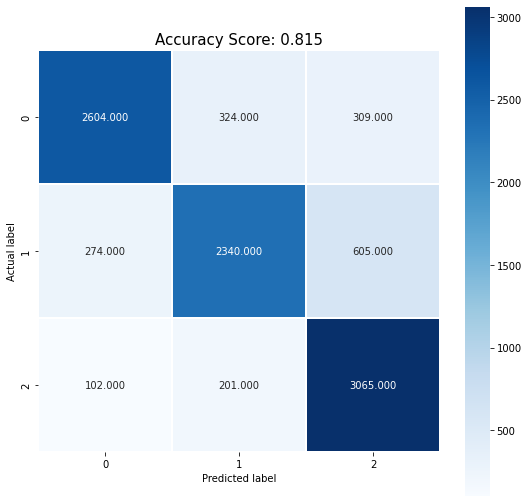

In [16]:
analysis_statistics(model, [test[0],test[1]], test[2], acc)
